In [11]:
from xml.etree import ElementTree as ET
import pandas as pd

tree = ET.parse('../data/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')


In [32]:
images = tree.getroot()[2]

# df = pd.DataFrame(columns=['file', 'width', 'height', 'box_top', 'box_left', 'box_width', 'box_height', 'label'])
dict = {
    'file': [],
    'width': [],
    'height': [],
    'box_top': [],
    'box_left': [],
    'box_width': [],
    'box_height': [],
    'label': []
}

for image in images:
    dict['file'].append(image.attrib['file'])
    dict['width'].append(int(image.attrib['width']))
    dict['height'].append(int(image.attrib['height']))
    dict['box_top'].append(int(image[0].attrib['top']))
    dict['box_left'].append(int(image[0].attrib['left']))
    dict['box_width'].append(int(image[0].attrib['width']))
    dict['box_height'].append(int(image[0].attrib['height']))
    label = []
    for part in image[0]:
        label.extend([int(part.attrib['x']), int(part.attrib['y'])])
    label_str = ' '.join([str(x) for x in label])
    dict['label'].append(label_str)
    
df = pd.DataFrame(dict, columns=['file', 'width', 'height', 'box_top', 'box_left', 'box_width', 'box_height', 'label'])

In [33]:
df.head(2)

,file,width,height,box_top,box_left,box_width,box_height,label
0,lfpw/trainset/image_0457.png,350,464,78,74,138,140,55 141 59 161 66 182 75 197 90 209 108 220 131...
1,helen/trainset/2659264056_1.jpg,576,768,130,31,447,447,107 150 99 238 97 314 98 375 107 439 133 493 1...


Visualize data

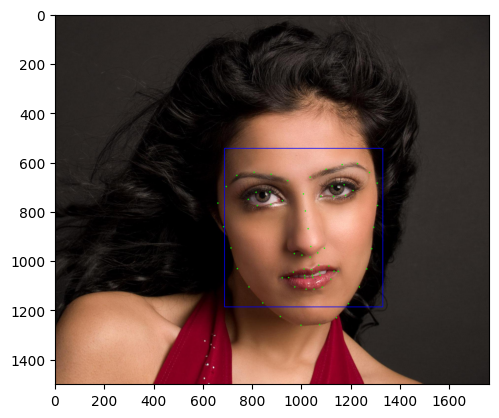

In [44]:
import cv2
import matplotlib.pyplot as plt

def show_image(df: pd.DataFrame, index: int):
    # image_path, labels, box=
    image_path = '../data/ibug_300W_large_face_landmark_dataset/' + df.iloc[index]['file']
    labels = [int(i) for i in df.iloc[index]['label'].split(' ')]
    box = df.iloc[index][['box_left', 'box_top', 'box_width', 'box_height']].values
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    landmarks = []
    for i in range(0, len(labels), 2):
        landmarks.append([labels[i], labels[i+1]])
    for landmark in landmarks:
        cv2.circle(image, (landmark[0], landmark[1]), 1, (0, 255, 0), 3)
    if box is not None:
        cv2.rectangle(image, (box[0], box[1]), (box[0]+box[2], box[1]+box[3]), (0, 0, 255), 2)
    plt.imshow(image)
    plt.show()

show_image(df, 5)

In [46]:
df.describe()

,width,height,box_top,box_left,box_width,box_height
count,6666.000000,6666.000000,6666.000000,6666.000000,6666.000000,6666.000000
mean,1254.492649,1177.724272,308.610861,389.968497,474.555656,474.586859
std,847.763054,758.811494,246.473192,345.005434,382.498656,382.118489
min,191.000000,183.000000,-370.000000,-422.000000,46.000000,47.000000
25%,600.000000,597.000000,125.000000,150.000000,216.000000,216.000000
50%,1004.000000,970.000000,259.000000,305.000000,372.000000,372.000000
75%,1685.000000,1615.000000,427.000000,513.000000,599.000000,596.000000
max,4773.000000,4917.000000,1950.000000,3637.000000,3068.000000,2761.000000
